Link for data set: https://archive.ics.uci.edu/dataset/9/auto+mpg

In [ ]:
%%capture
pip install ucimlrepo

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
auto_mpg = fetch_ucirepo(id=9)

# data (as pandas dataframes)
X = auto_mpg.data.features
y = auto_mpg.data.targets
z  = auto_mpg.data.ids

# metadata
# print(auto_mpg.metadata)

# # variable information
# print(auto_mpg.variables)

def fix_names(s):
  names = s.split(',')
  full_car_name = ''
  for i in range(len(names)):
    full_car_name = full_car_name + ' ' +names[i]
  return full_car_name
z = z['car_name'].apply(fix_names)
auto_mpg_data = pd.concat([z,X,y], axis = 1)

auto_mpg_data['horsepower'] = (
    pd.to_numeric(auto_mpg_data['horsepower'], errors='coerce'))

auto_mpg_data.head()

,car_name,displacement,cylinders,horsepower,weight,acceleration,model_year,origin,mpg
0,chevrolet chevelle malibu,307.0,8,130.0,3504,12.0,70,1,18.0
1,buick skylark 320,350.0,8,165.0,3693,11.5,70,1,15.0
2,plymouth satellite,318.0,8,150.0,3436,11.0,70,1,18.0
3,amc rebel sst,304.0,8,150.0,3433,12.0,70,1,16.0
4,ford torino,302.0,8,140.0,3449,10.5,70,1,17.0


In [ ]:
#initial steps for EDA

print('DataFrame Info')
auto_mpg_data.info()

print('Descriptive Statistics')
print(auto_mpg_data.describe())

print('Missing Values Count')
print(auto_mpg_data.isnull().sum())

DataFrame Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   car_name      398 non-null    object 
 1   displacement  398 non-null    float64
 2   cylinders     398 non-null    int64  
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   mpg           398 non-null    float64
dtypes: float64(4), int64(4), object(1)
memory usage: 28.1+ KB
Descriptive Statistics
       displacement   cylinders  horsepower       weight  acceleration  \
count    398.000000  398.000000  392.000000   398.000000    398.000000   
mean     193.425879    5.454774  104.469388  2970.424623     15.568090   
std      104.269838    1.701004   38.491160   846.841774      2.757689   
min       68.000000    3.0

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

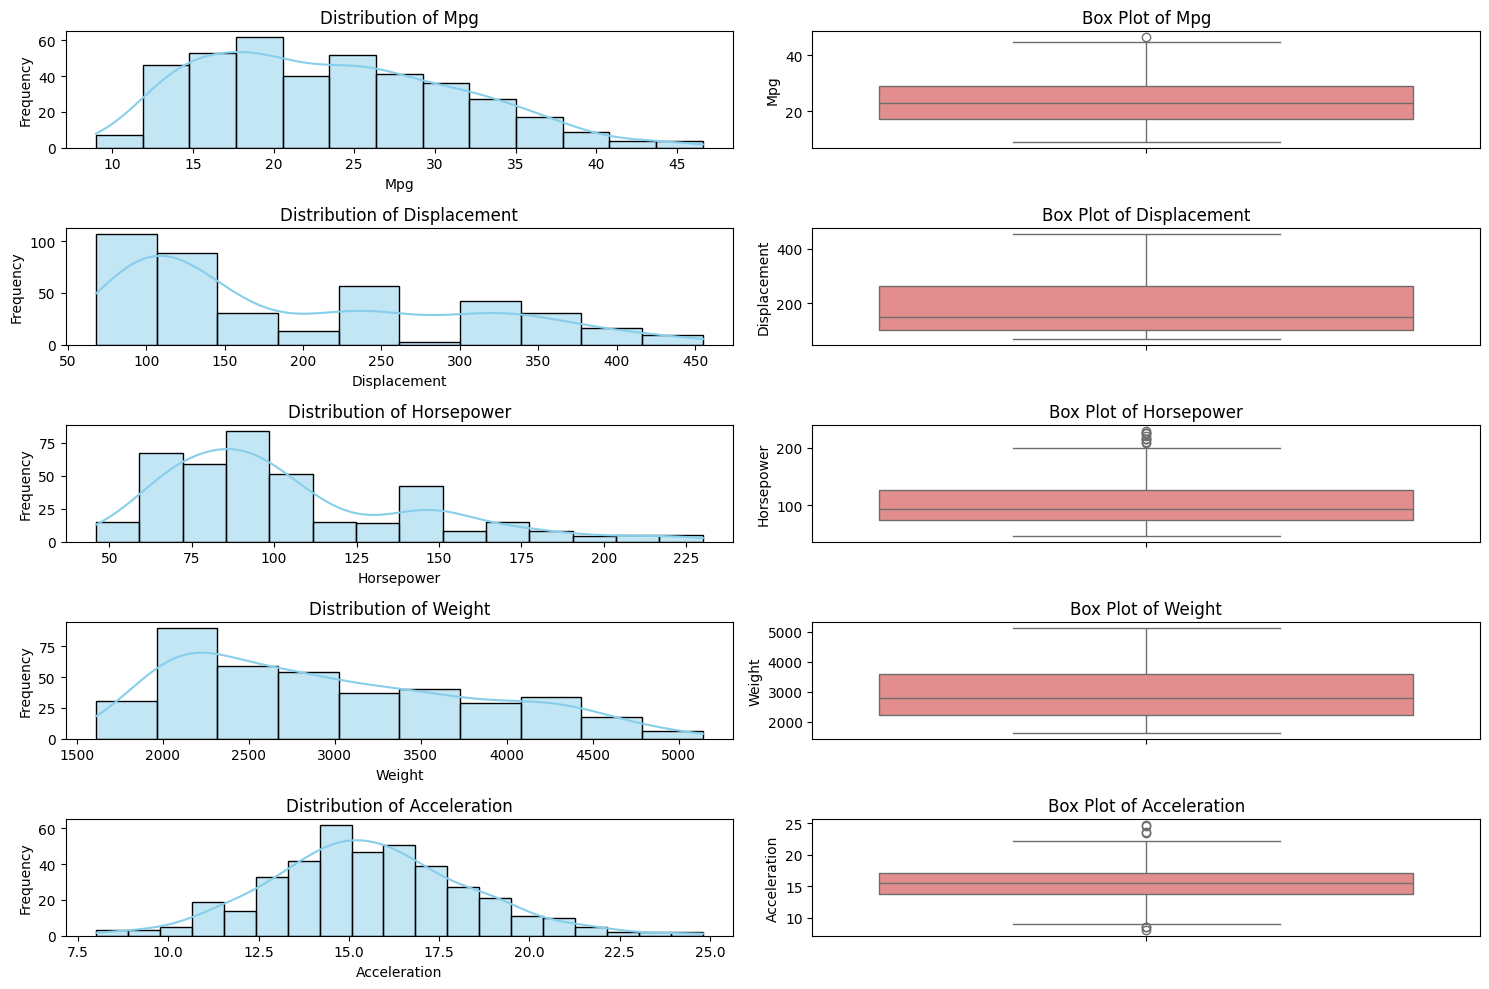

In [ ]:
numerical_features = ['mpg', 'displacement', 'horsepower', 'weight', 'acceleration']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(len(numerical_features), 2, 2*i + 1)
    sns.histplot(auto_mpg_data[col], kde=True, color='skyblue')
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Frequency')

    plt.subplot(len(numerical_features), 2, 2*i + 2)
    sns.boxplot(y=auto_mpg_data[col], color='lightcoral')
    plt.title(f'Box Plot of {col.replace("_", " ").title()}')
    plt.ylabel(col.replace("_", " ").title())

plt.tight_layout()
plt.show()

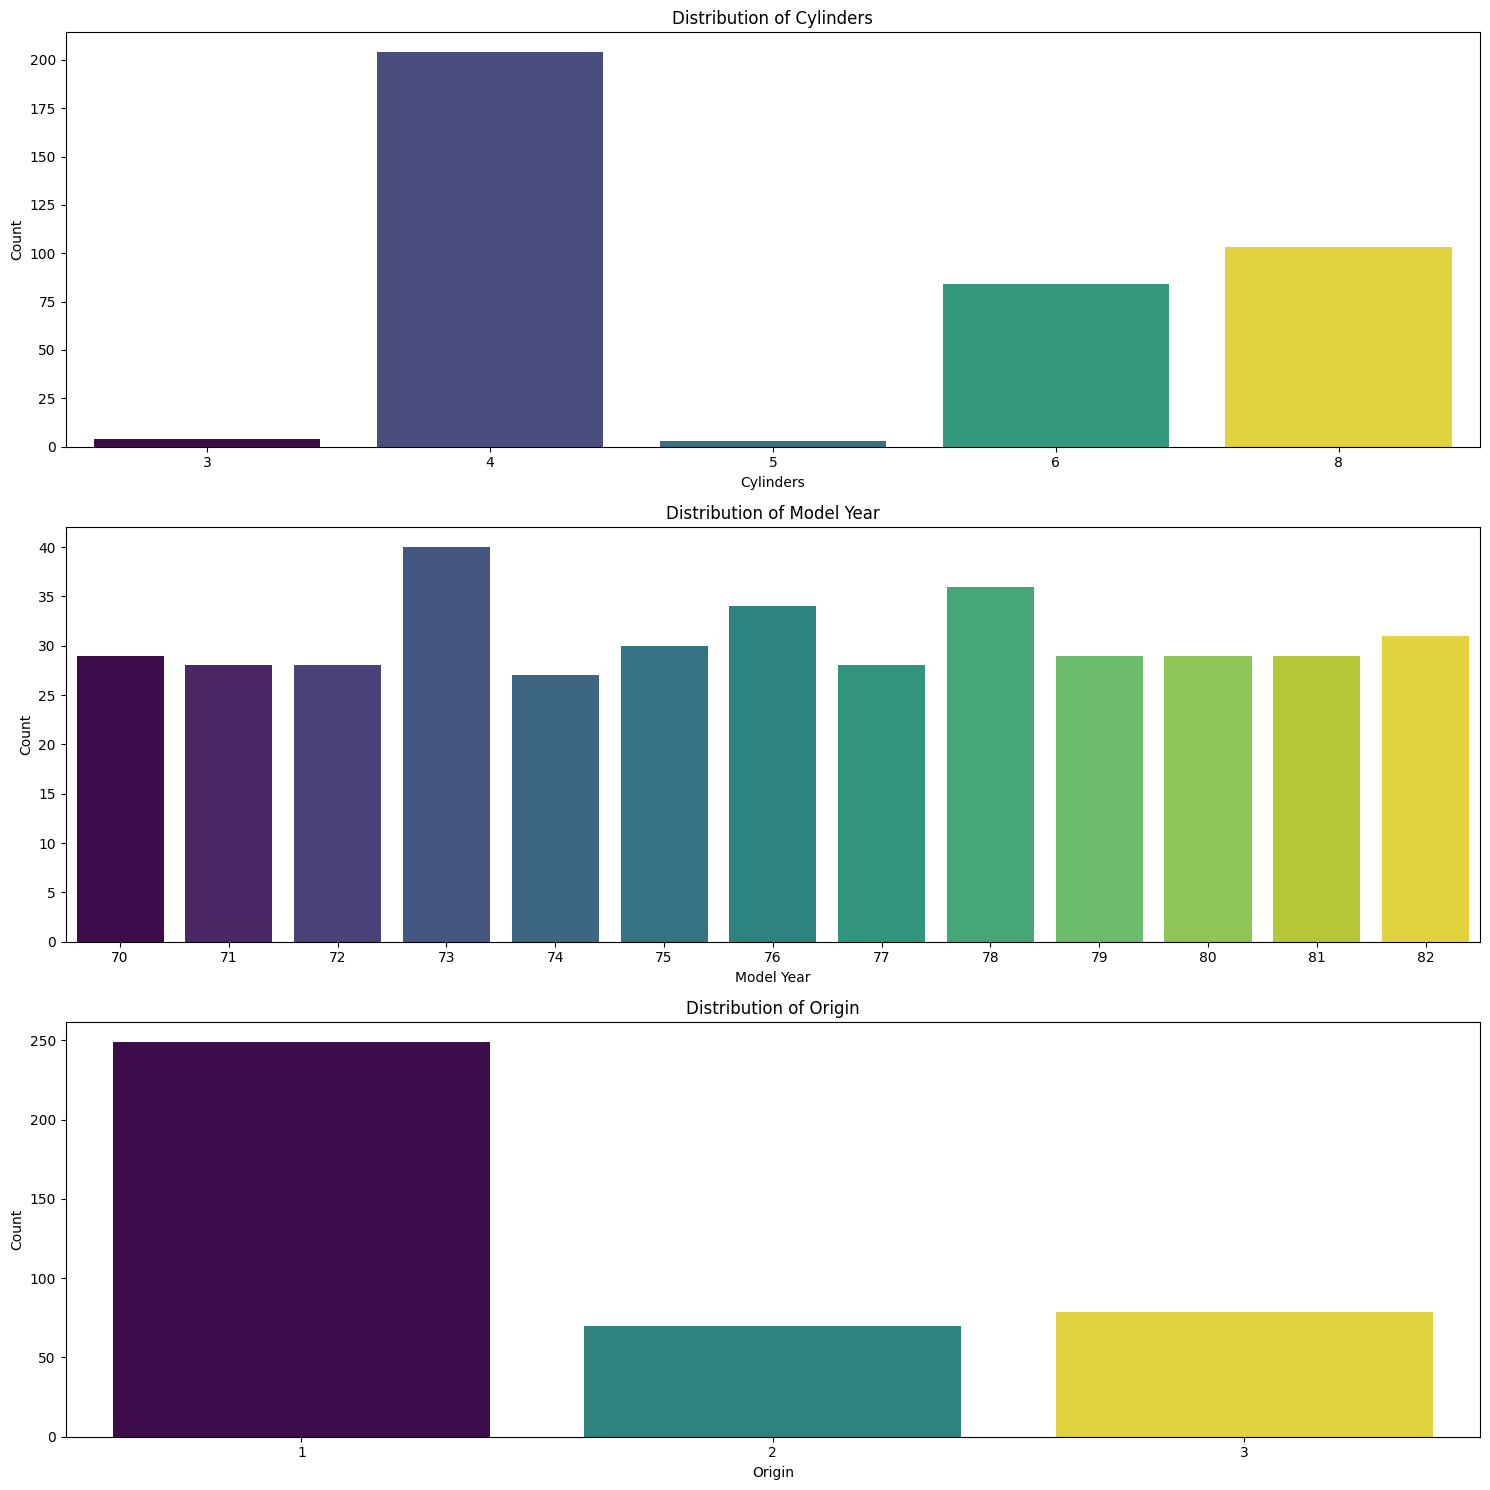

In [ ]:
categorical_features = ['cylinders', 'model_year', 'origin']

plt.figure(figsize=(15, 5 * len(categorical_features)))
for i, col in enumerate(categorical_features):
    plt.subplot(len(categorical_features), 1, i + 1)
    sns.countplot(x=auto_mpg_data[col], hue=auto_mpg_data[col], palette='viridis', legend=False)
    plt.title(f'Distribution of {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

In [ ]:
numerical_features_for_correlation = ['mpg', 'displacement', 'cylinders', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin']
correlation_matrix = auto_mpg_data[numerical_features_for_correlation].corr(method='pearson')

print('Correlation Matrix')
print(correlation_matrix)

Correlation Matrix
                   mpg  displacement  cylinders  horsepower    weight  \
mpg           1.000000     -0.804203  -0.775396   -0.778427 -0.831741   
displacement -0.804203      1.000000   0.950721    0.897257  0.932824   
cylinders    -0.775396      0.950721   1.000000    0.842983  0.896017   
horsepower   -0.778427      0.897257   0.842983    1.000000  0.864538   
weight       -0.831741      0.932824   0.896017    0.864538  1.000000   
acceleration  0.420289     -0.543684  -0.505419   -0.689196 -0.417457   
model_year    0.579267     -0.370164  -0.348746   -0.416361 -0.306564   
origin        0.563450     -0.609409  -0.562543   -0.455171 -0.581024   

              acceleration  model_year    origin  
mpg               0.420289    0.579267  0.563450  
displacement     -0.543684   -0.370164 -0.609409  
cylinders        -0.505419   -0.348746 -0.562543  
horsepower       -0.689196   -0.416361 -0.455171  
weight           -0.417457   -0.306564 -0.581024  
acceleration     

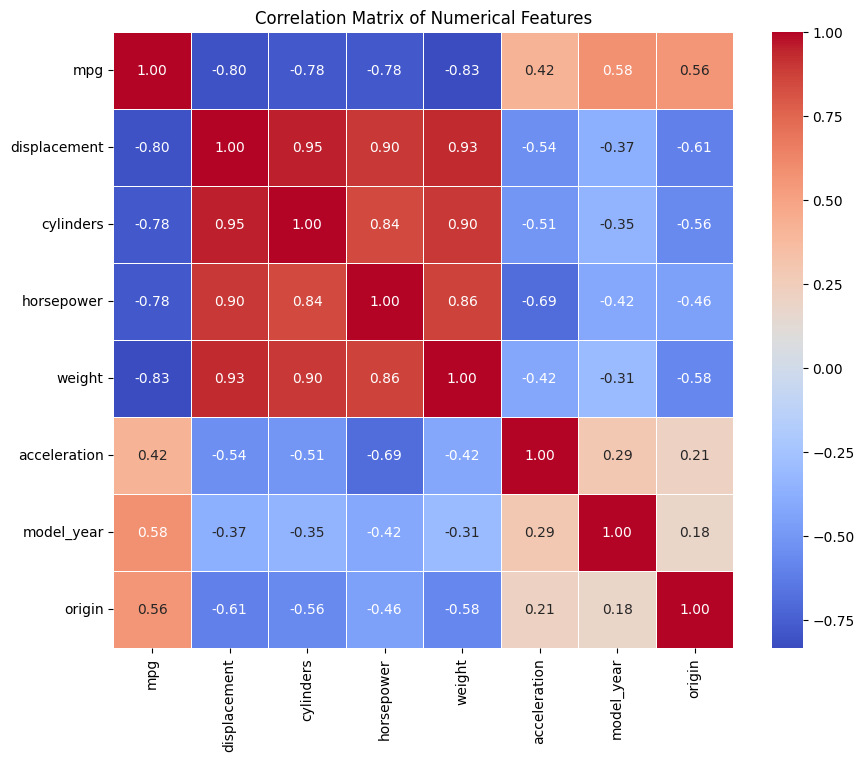

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


--- Features Most Correlated with MPG ---

mpg             1.000000
model_year      0.579267
origin          0.563450
acceleration    0.420289
cylinders      -0.775396
horsepower     -0.778427
displacement   -0.804203
weight         -0.831741
Name: mpg, dtype: float64

--- Highly Correlated Features ---

['weight', 'displacement', 'horsepower', 'cylinders', 'model_year', 'origin', 'acceleration']


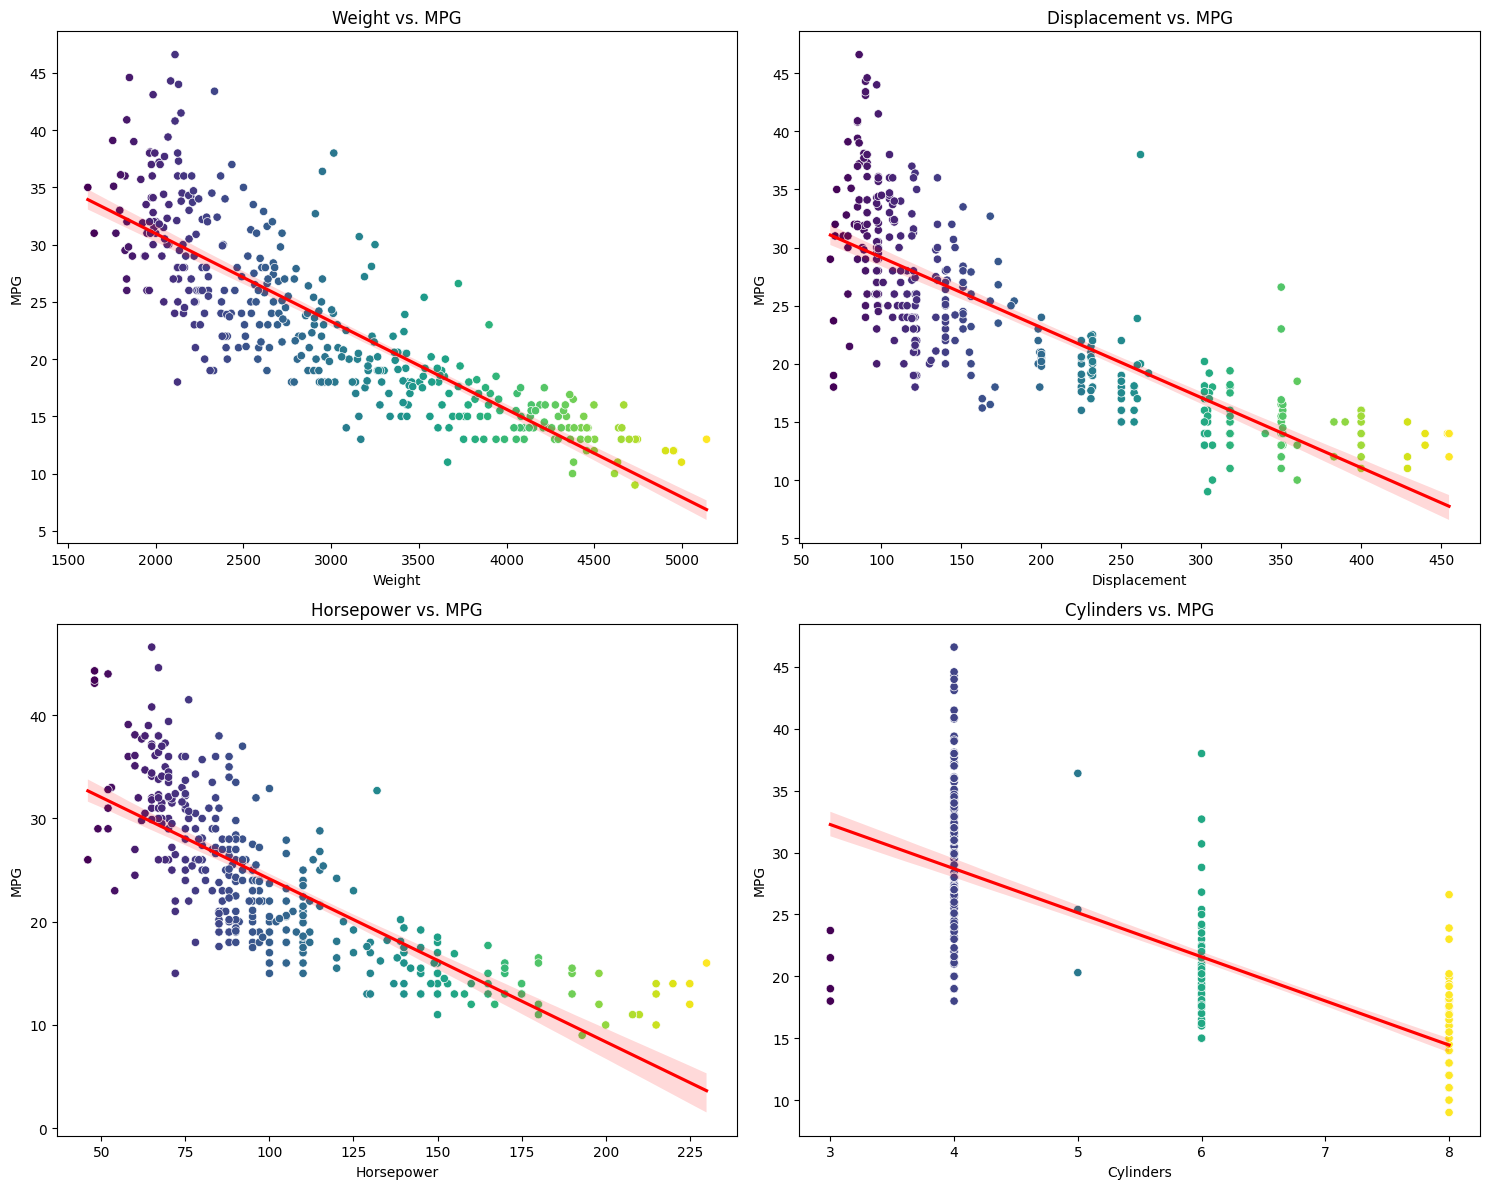

In [ ]:
mpg_correlations = correlation_matrix['mpg'].sort_values(ascending=False)
print('\n--- Features Most Correlated with MPG ---\n')
print(mpg_correlations)

highly_correlated_features = mpg_correlations.drop('mpg').abs().sort_values(ascending=False).index.tolist()
print('\n--- Highly Correlated Features ---\n')
print(highly_correlated_features)
selected_features_for_scatter = highly_correlated_features[:4]

plt.figure(figsize=(15, 12))
for i, feature in enumerate(selected_features_for_scatter):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x=auto_mpg_data[feature], y=auto_mpg_data['mpg'], hue=auto_mpg_data[feature], palette='viridis', legend=False)
    sns.regplot(x=auto_mpg_data[feature], y=auto_mpg_data['mpg'], scatter=False, color='red')
    plt.title(f'{feature.replace("_", " ").title()} vs. MPG')
    plt.xlabel(feature.replace("_", " ").title())
    plt.ylabel('MPG')

plt.tight_layout()
plt.show()

In [ ]:
#combine displacement and cylinders, displacement is total volume of cylinders
#combine displacement and weight since they are closely related
auto_mpg_data_clean = auto_mpg_data.drop(['cylinders', 'weight'], axis =1)
auto_mpg_data_clean.head()

,car_name,displacement,horsepower,acceleration,model_year,origin,mpg
0,chevrolet chevelle malibu,307.0,130.0,12.0,70,1,18.0
1,buick skylark 320,350.0,165.0,11.5,70,1,15.0
2,plymouth satellite,318.0,150.0,11.0,70,1,18.0
3,amc rebel sst,304.0,150.0,12.0,70,1,16.0
4,ford torino,302.0,140.0,10.5,70,1,17.0


In [ ]:
target = "mpg"

X = auto_mpg_data.drop(columns=[target])
y = auto_mpg_data[target]

X.head(), y.head()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

numeric_features = ["displacement", "horsepower", "weight", "acceleration"]
categorical_features = ["origin", "cylinders", "model_year"]

# optional: use car_name as text later, but start simple by dropping it
drop_features = ["car_name"]

X_train2 = X_train.drop(columns=drop_features)
X_test2  = X_test.drop(columns=drop_features)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features),
    ]
)



#playing around with some different models here

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_validate

models = {
    "Dummy(mean)": DummyRegressor(strategy="mean"),
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(
        n_estimators=400, random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}

scoring = {
    "rmse": "neg_root_mean_squared_error",
    "r2": "r2"
}

results = []
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    cv = cross_validate(pipe, X_train2, y_train, cv=5, scoring=scoring)
    results.append({
        "model": name,
        "cv_rmse_mean": -cv["test_rmse"].mean(),
        "cv_rmse_std": cv["test_rmse"].std(),
        "cv_r2_mean": cv["test_r2"].mean(),
    })

results_df = pd.DataFrame(results).sort_values("cv_rmse_mean")
results_df


,model,cv_rmse_mean,cv_rmse_std,cv_r2_mean
2,Ridge,2.986531,0.263388,0.854810
3,Lasso,2.993240,0.264337,0.854173
1,Linear,2.999277,0.275251,0.853172
5,GradientBoosting,3.386358,0.383817,0.812672
4,RandomForest,3.406875,0.511513,0.808737
0,Dummy(mean),7.932548,0.438764,-0.019312


In [ ]:
target = "mpg"

X_clean = auto_mpg_data_clean.drop(columns=[target])
y_clean = auto_mpg_data_clean[target]

X_clean.head(), y_clean.head()

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

numeric_features = ["displacement", "horsepower", "acceleration"]
categorical_features = ["origin", "model_year"]

# optional: use car_name as text later, but start simple by dropping it
drop_features = ["car_name"]

X_train2 = X_train.drop(columns=drop_features)
X_test2  = X_test.drop(columns=drop_features)

preprocess = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features),
    ]
)



#playing around with some different models here

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_validate

models = {
    "Dummy(mean)": DummyRegressor(strategy="mean"),
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "RandomForest": RandomForestRegressor(
        n_estimators=400, random_state=42, n_jobs=-1
    ),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}

scoring = {
    "rmse": "neg_root_mean_squared_error",
    "r2": "r2"
}

results = []
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    cv = cross_validate(pipe, X_train2, y_train, cv=5, scoring=scoring)
    results.append({
        "model": name,
        "cv_rmse_mean": -cv["test_rmse"].mean(),
        "cv_rmse_std": cv["test_rmse"].std(),
        "cv_r2_mean": cv["test_r2"].mean(),
    })

clean_results_df = pd.DataFrame(results).sort_values("cv_rmse_mean")

In [ ]:
from IPython.display import display_html

def display_side_by_side(df1, df2, caption1, caption2):
  df1_style = df1.style.set_table_attributes("style='display:inline; margin-right: 20px;'").set_caption(caption1)
  df2_style = df2.style.set_table_attributes("style='display:inline'").set_caption(caption2)
  display_html(df1_style._repr_html_() + df2_style._repr_html_(), raw=True)

display_side_by_side(results_df, clean_results_df, 'Results', 'Clean Results')

,model,cv_rmse_mean,cv_rmse_std,cv_r2_mean
2,Ridge,2.986531,0.263388,0.854810
3,Lasso,2.993240,0.264337,0.854173
1,Linear,2.999277,0.275251,0.853172
5,GradientBoosting,3.386358,0.383817,0.812672
4,RandomForest,3.406875,0.511513,0.808737
0,Dummy(mean),7.932548,0.438764,-0.019312
,model,cv_rmse_mean,cv_rmse_std,cv_r2_mean
5,GradientBoosting,3.287387,0.442222,0.821763
4,RandomForest,3.417847,0.463091,0.808458
2,Ridge,3.579551,0.183982,0.791981


In [ ]:
#trying grandiant boosting model
x_train, x_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)


In [ ]:
#also just trying to mess around with an ensemble model to see what thats like

from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline

ensemble = VotingRegressor(estimators=[
    ("ridge", Ridge(alpha=1.0)),
    ("rf", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=-1)),
    ("gbr", GradientBoostingRegressor(random_state=42)),
])

vote = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", ensemble)
])

vote.fit(X_train2, y_train)
pred = vote.predict(X_test2)

from sklearn.metrics import mean_squared_error, r2_score

rmse = mean_squared_error(y_test, pred, squared=False)
r2 = r2_score(y_test, pred)

print("RMSE:", rmse)
print("R2:", r2)


TypeError: got an unexpected keyword argument 'squared'